> # Intro
Airbnb Data Analysis (Fork)


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap
import os

## 1.2 The listings and listing details files
The dataset that I created contains a total of 7 files. The listings file is an overview file that insideairbnb labels as "good for visualizations". The unique identifier in the dataset is the "listing" id. This is basically the id of the advertisement. Overall, there were 20,030 Airbnb-listings in Amsterdam on December 6th, 2018.

In [2]:
print(os.listdir("../input"))

['listings.csv', 'calendar.csv', 'neighbourhoods.csv', 'reviews.csv', 'reviews_details.csv', 'neighbourhoods.geojson', 'listings_details.csv']


In [3]:
listings = pd.read_csv("../input/listings.csv")
listings_details = pd.read_csv("../input/listings_details.csv", low_memory=False)
print(listings.shape)

(20030, 16)


The listings file contains 15 variables per listing besides the id.

In [4]:
listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

The listings_details file contains a total of 96 variables. I am not going to use all of these, but selectively joined a number of variables that seemed useful to me for this EDA.

In [5]:
target_columns = ["id", "property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 0 to 20029
Data columns (total 36 columns):
id                                20030 non-null int64
name                              19992 non-null object
host_id                           20030 non-null int64
host_name                         20026 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     20030 non-null object
latitude                          20030 non-null float64
longitude                         20030 non-null float64
room_type                         20030 non-null object
price                             20030 non-null int64
minimum_nights                    20030 non-null int64
number_of_reviews                 20030 non-null int64
last_review                       17624 non-null object
reviews_per_month                 17624 non-null float64
calculated_host_listings_count    20030 non-null int64
availability_365                  20030 non-null int64
pr

We see that neighbourhood_group is useless in Amsterdam, as it contains zero non-null objects. Below, I getting rid of this variable, and am showing the head of the dataframe that I am going to work with.

In [6]:
listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,property_type,accommodates,first_review,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,1,44,Apartment,2,2009-03-30,10.0,10.0,9.0,10.0,10.0,10.0,97.0,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
1,3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,1,47,Apartment,5,2015-07-31,9.0,9.0,9.0,10.0,10.0,10.0,96.0,20,https://www.airbnb.com/rooms/3209,f,I am a freelance radio producer and journalist...,within an hour,100.0,"Amsterdam, Noord-Holland, Netherlands",$543.00,"$2,000.00",Amsterdam
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,2,198,Townhouse,2,2010-03-02,9.0,10.0,10.0,9.0,9.0,9.0,87.0,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within a few hours,100.0,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
3,25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,2,141,Apartment,3,2018-01-21,10.0,10.0,10.0,10.0,10.0,10.0,100.0,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within a few hours,100.0,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
4,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150,2,171,2018-11-25,2.03,1,199,Houseboat,2,2012-01-09,10.0,10.0,10.0,10.0,10.0,10.0,99.0,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam


# 2. Data exploration
## 2.1 Neighbourhoods
Neighbourhood "De Baarsjes" holds most listings, and altogether eight neigbourhoods have over one thousand listings.



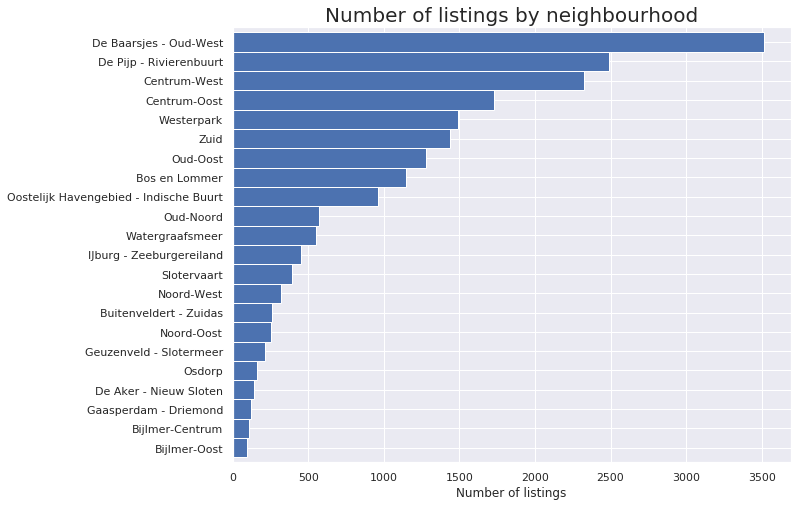

In [7]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=18)
plt.xlabel('Number of listings', fontsize=10)
plt.show()

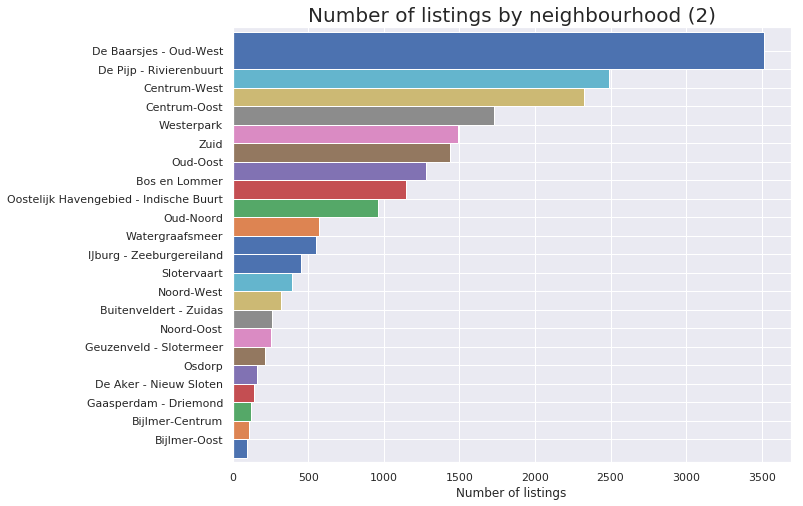

In [18]:
#An alternative to the bar chart above with a few changes
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), width=2)
plt.title("Number of listings by neighbourhood (2)", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)

plt.show()

Below, you can see that most listings are in the city centre. This map is interactive, and you can zoom-in on the clusters to eventually find the individual locations of the listings.

Note: In a later version I made a map on the average daily price per neighoudhood (section 4.1). I think this map would also be better at this point (as it uses the neighbourhood shapefile), but as my main goal of this kernel is to learn as much as possible I left the map below unchanged as FastMarkerCluster will be useful in the future.

In [ ]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

## 2.2 Room types and property types
### 2.2.1 Room types
The room type is very important in Amsterdam, because Amsterdam has a rule that Entire homes/apartments can only be rented out via Airbnb for a maximum of 60 days a year. Below, we can see that this restriction applies to most of the listings.

In [ ]:
freq = listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"])
plt.show()

### 2.2.2 Property types
In the dataset, we find a lot of different property types.

In [ ]:
listings.property_type.unique()

However, many of those property types have very few listings in Amsterdam. In the figure below, I am only displaying property types with at least 100 listings. As we can see, the vast majority of the properties in Amsterdam are apartments.

In [ ]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Amsterdam', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

## 2.3 Accommodates (number of people)
As expected, most listings are for 2 people. In addition, Airbnb uses a maximum of 16 guests per listing.

In [ ]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

However, Amsterdam has an additional restriction. Due to fire hazard considerations and also taking possible noisy group into account, owners are only allowed to rent their property to groups with a maximum of 4 people. This actually means that the listings that indicate that the maximum number of people is above 4 are breaking thia rule!

# 3. Advice to the municipality of Amsterdam

It is known that Airbnb causes problems in Amsterdam. These problems are described well in this article: [Fed Up With Tourists, Amsterdam Gets Tough On Airbnb, Tourist Taxes And Too Much Partying](https://www.forbes.com/sites/ceciliarodriguez/2018/05/17/amsterdam-overwhelmed-by-tourists-gets-tough-on-airbnb-tourists-taxes-too-much-partying/#5c6c78892be5)

>The coalition of parties forming the city’s new government wants to follow the examples of Barcelona and Venice, where the flood of unruly tourism has made life extremely unpleasant for residents, forcing  officials to try to control the number of visitors and their behavior.

Extra rules that Amsterdam has in place when compared to Airbnb's own rules are:

* The maximum number of guests is 4 (see also previous section)
* The maximum number short-term rental is 60 days. This rules is only for renting out Entire properties, and therefore does not apply to renting out Private Rooms. This rule was already enforced by Airbnb (after 60 days of bookings, Airbnb closes the availability of the listing for the rest of the year). As you can read in the article, this number will be lowered to 30 days a year.
* Amsterdam intends to ban Airbnb entirely in three neighourhoods: de Wallen (Red Light District), Kinkerbuurt and Haarlemmerbuurt
* For renting out Private Rooms, there is also the restriction that an owner cannot rent-out rooms that accumulate to more than 40% of total space (in square meters)

## 3.1 Finding possibly illegal hotels
Any owner renting out more than 40% of his/her property as Private Rooms is breaking the last rule mentioned in the previous section, but in this section I am only going to look for extreme cases.

Below, I am displaying the  five hosts having the most Private Room listings. Unfortunately, Airbnb does not give the addresses of the listings. The field "street" is actually in the database, but as you can see these are certainly not full, real addresses! Therefore, from this table I cannot say if these listings from are in fact in the same house.


In [ ]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'street']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

However, we have the GPS-coordinates of the listings. To me, it seems very likely that all private rooms that Feliciano offers are in fact in the same building (only minor variations in latitude/longitude). Although this host might have a hotel license, his listings seems suspicius too me (what is the name of the hotel?)! I would advise the municipality of Amsterdam to check if no rules are broken in this case.

In [ ]:
feliciano = private[private['host_id']== 67005410]
feliciano = feliciano[['id', 'name','host_name', 'latitude', 'longitude']]
feliciano

## 3.2 Unwanted effects of professional hosts?
At the moment, Amsterdam has no rules in place to prevent professional hosting activities. I can imagine that having the option to outsource these activities leads to even more listings. At the moment, about 75% of the hosts only have one listing. I can imagine that hosts with a couple of listings are likely to just also be the hosts for a couple of friends. However, we see that there are extreme cases. I believe that it becomes unlikely that hosts with more than 10 listings are just doing this for themselves and friends and family.

In [ ]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop



Below, I diplay the hosts with more that 20 listings. Unfortunately, the host_about is not fully scraped. However as this dataset is extremely recent, it was not hard for me to find the host description of the host with 200+ listings on airbnb.com. As you can see, this host clearly is a professional host!

As it is probably hard to implement and control a measure that completely forbids professional hosting activities, I would advise the municipality of Amsterdam to consider setting a maximum number of listings per host that is allowed in Amsterdam. If Amsterdam would set this at for instance 10 (and manages to get this implemented in Airbnb's systems), it would becomes much harder to exploit hosting at Airbnb as a professional activity.

In [ ]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

Hosted by Martijn

Amsterdam, Netherlands · Joined in April 2016

Martijn User Profile: 1928 Reviews, Verified

Hi, I'm Martijn, We are a team of professional hosts established by travelers just like you. We believe in sharing homes. Wherever you are, it is delightful to explore and discover an unknown city from an authentic home. On behalf of home owners we advertise their properties through our airbnb profile and support them by offering you a pleasant stay. When you book your holiday with us, you can be confident of a memorable stay and an experience through the eyes of a local. We are more than happy to share our knowledge, give you the best insider tips and recommendations about Amsterdam. If you have any questions, holiday wishes or simply want to have a chat, then feel free to contact us any time. We always reply within an hour! We look forward to being your host! :)

# 4. Advice to the tourists
## 4.1 Average daily price per neighbourhood
In order to compare "apples to apples" I have only selected the most common type of accommodation, which is accommodation for 2 persons. As expected, accommodation in the city centre is the most expensive. 

In [ ]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

Below you can find the neighbourhoods on a map. This map is **interactive**. Hovering over the polygons shows the name of the neighbourhood, and the average price for 2-persons accommodations.

In [ ]:
adam = gpd.read_file("../input/neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

## 4.2 Neighbourhood safety
As there is no data on neighbourhood safety in the Airbnb files, I searched for this online and came across the map below. As you can see, nowadays the western parts of the city are the most dangerous.

Personal note: Apparently "de Bijlmer" (south-eastern areas) is reasonably safe these days. However, I used to know somebody who lived there as a student years ago. At that time it certainly was not a good neighbourhood, and I was warned to "stay under the balconies" as people might throw rubbish and old furniture from their balconies. Getting an old couch on your head did not sound like the most pleasant thing in the world ;-).

<center><img src="https://i.imgur.com/7cso9GD.png" style="width: 800px;"/></center>

## 4.3 Review scores location, and location scores versus price
In tis section, I am grouping the review scores for the location by neighbourhood (only listings with at least 10 reviews). Although I expect the distance to the city centre to an important factor, these score should also take other things into account. Other factors may include:

* The safety of a location (as displayed in the previous section)
* Noise. If a listing is centrally located, but surrounded by noisy bars, that should cost point in the location review score.
* If a listing is located outside the city centre but well connected by public transportation,  it should get bonus points for that.
* Facilities near the listing. Are there any supermarkets, bars and restaurants nearby?
* Some people may be looking for free parking, if they come by car (parking is very expensive in Amsterdam in general).

Below we see that the central neighbourhoods, which were generally also the most expensive, generally also score higher on location review score.  If I would calculate the distance to the city centre for each listing, I expect to see pretty strong correlations between this distance with both price and location review score.

When looking at the average review score, I am surprised to see that the average is above 8/10 for all neighbourhoods! I know that Amsterdam is a small city (much smaller than many people might think!). Therefore, it does not take much time to get to the city centre from anywhere, which might explain the high averages to a certain extend. My personal advice to tourists would be to consider more affordable accommodation outside the city centre, in a safe neighbourhood, and with good public transportation connections to the city centre anyway. However, are the differences between the best locations and outside neighbourhoods really that small? Let's find out in the next section!


In [ ]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

## 4.4 How to use review scores
In addition to written reviews, guests can submit an overall star rating and a set of category star ratings. Guests can give ratings on:

* Overall Experience. What was your guest’s overall experience?
* Cleanliness. Did your guests feel that your space was clean and tidy?
* Accuracy. How accurately did your listing page represent your space?
* Value. Did your guest feel your listing provided good value for the price?
* Communication. How well did you communicate with your guest before and during their stay?
* Arrival. How smoothly did their check-in go?
* Location. How did guests feel about your neighborhood?

Below you can see the scores distribution of all those categories. What caught my eye immediately is that scores seem really high across the board! A quick internet search told me that this seems common across Airbnb. It is explained well in this article: [Higher than the average rating? 95% of Airbnb listings rated 4.5 to 5 stars](https://mashable.com/2015/02/25/airbnb-reviews-above-average/?europe=true#1YLfzOC34sqd).

After having seen the scores distributions, I would personally consider any score of 8 or lower to be not a good score. If I wanted to use any of these scores in a search for accomodation, I believe the "Value" seems most useful. First of all, I always like to get good value for money ;-). However, the number of "10 averages" is reasonably small, which makes the indicator a bit more "distinguishable" than other indicators.

In [ ]:
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

## 4.5 Finding a good host
At Airbnb you can get the status "Superhost". From Airbnb:
* As a Superhost, you’ll have more visibility, earning potential, and exclusive rewards. It's our way of saying thank you for your outstanding hospitality.
* How to become a Superhost: Every 3 months, we check if you meet the following criteria. If you do, you'll earn or keep your Superhost status.
    * Superhosts have a 4.8 or higher average overall rating based on reviews from at least 50% of their Airbnb guests in the past year. 
    * Superhosts have hosted at least 10 stays in the past year or, if they host longer-term reservations, 100 nights over at least 3 stays. 
    * Superhosts have no cancellations in the past year, unless there were extenuating circumstances.
    * Superhosts respond to 90% of new messages within 24 hours.

Below, we can see that only a small portion of the listings in Amsterdam do have a host who is Superhost.

In [ ]:
feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

If I were to book accomomodation, I would not necessarily look for a superhost. Actually, I would be afraid that I would pay too much as superhost will likely increase their prices. However, I would also not want to host that responds badly, or cancels a lot.

As we can see, over 5,000 of the 20,000 listings have at least 10 reviews and respond to at least 90% of the new messages. I would consider those hosts "proven" good responders (which does not mean that a listing with less than 10 reviews cannot have good responding hosts; it is just not proven yet). Also, there are very few listings with hosts not replying to new messages within 24 hours.

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

In [ ]:
listings.host_response_rate.unique()

In [ ]:
listings['host_response_rate'].max()
feq1

In [ ]:
listings['review_scores_cleanliness'].value_counts()

In [ ]:
#feq = listings[listings['number_of_reviews']>=10]
feq = listings
feq1 = feq.groupby('neighbourhood')['review_scores_location'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
feq1

If you are interested to see what you can do with `Lealet for R` (the R alternative of Folium), please have a look at two of my previous kernels:
* [Gun violence in the US: Interactive maps and EDA](https://www.kaggle.com/erikbruin/gun-violence-in-the-us-interactive-maps-and-eda)
* [Recommendations to PASSNYC (1st place solution)](https://www.kaggle.com/erikbruin/recommendations-to-passnyc-1st-place-solution)



[](http://)**To be continued!**